In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input, Reshape, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
def ConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2D(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation(leakyrelu)(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def deConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2DTranspose(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation('relu')(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

In [4]:
# average
class RaGAN(keras.Model):
    def __init__(self, x_dim, z_dim): # dim: tuple
        super(RaGAN, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(RaGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        inputs = Input(shape = self.z_dim)
        
        h = Dense(128*7*7, activation='relu')(inputs)
        h = Reshape((7, 7, 128))(h) # 7, ,7 128
        h = BatchNormalization(momentum=0.8)(h)
        h = deConvBlock(64)(h) # 14, 14, 64
        h = deConvBlock(32)(h) # 28, 28, 32
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(h) # 28, 28, 1
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape = self.x_dim)
        
        h = ConvBlock(16)(inputs)
        h = ConvBlock(32)(h)
        h = ConvBlock(64)(h)
        h = Flatten()(h)
        
        outputs = Dense(1)(h)
        return Model(inputs, outputs, name='discriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            fake_pred = self.discriminator(fake)
            real_pred = self.discriminator(x)
            
            fake_loss = self.loss_fn(fake_labels, fake_pred - tf.reduce_mean(real_pred, 0))
            real_loss = self.loss_fn(real_labels, real_pred - tf.reduce_mean(fake_pred, 0))

            d_loss = 0.5*(fake_loss + real_loss)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            preds = self.generator(noise)
            fake_pred = self.discriminator(preds)
            real_pred = self.discriminator(x)
            
            g_loss = self.loss_fn(real_labels, fake_pred - tf.reduce_mean(real_pred, 0))
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}



In [5]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 100))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [6]:
# prepare data
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = np.expand_dims(train_X, -1)


In [7]:
gan = RaGAN(train_X.shape[1:], 100)

In [8]:
gan.generator.summary()
gan.discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        73792     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        25

In [9]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

In [10]:
df = tf.data.Dataset.from_tensor_slices(train_X)
df = df.batch(32).prefetch(1)

Epoch 1/100
1872/1875 [============================>.] - ETA: 0s - d_loss: 0.4451 - g_loss: 1.8147

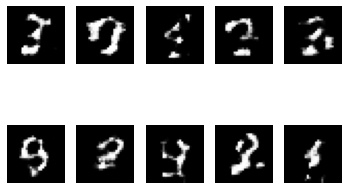

1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.4449 - g_loss: 1.8139
Epoch 2/100
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.4884 - g_loss: 1.2928
Epoch 3/100
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.4912 - g_loss: 1.3990
Epoch 4/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5086 - g_loss: 1.3780
Epoch 5/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5015 - g_loss: 1.4084
Epoch 6/100
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.5045 - g_loss: 1.4285
Epoch 7/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5097 - g_loss: 1.4337
Epoch 8/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5206 - g_loss: 1.4136
Epoch 9/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5313 - g_loss: 1.3874
Epoch 10/100
1875/1875 [==============================] - 18s 10ms/

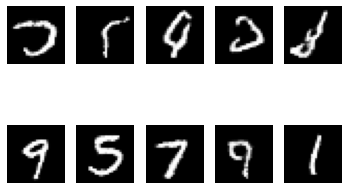

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5499 - g_loss: 1.3250
Epoch 12/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5621 - g_loss: 1.2913
Epoch 13/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5693 - g_loss: 1.2593
Epoch 14/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5773 - g_loss: 1.2321
Epoch 15/100
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.5806 - g_loss: 1.2033
Epoch 16/100
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.5849 - g_loss: 1.1888
Epoch 17/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5889 - g_loss: 1.1601
Epoch 18/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5921 - g_loss: 1.1510
Epoch 19/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5978 - g_loss: 1.1239
Epoch 20/100
1875/1875 [==============================] - 1

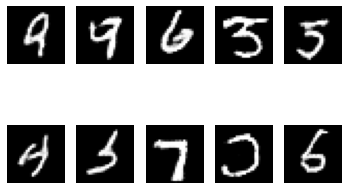

1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6019 - g_loss: 1.1088
Epoch 22/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6091 - g_loss: 1.0815
Epoch 23/100
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6110 - g_loss: 1.0676
Epoch 24/100
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6126 - g_loss: 1.0607
Epoch 25/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6149 - g_loss: 1.0481
Epoch 26/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6157 - g_loss: 1.0464
Epoch 27/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6137 - g_loss: 1.0449
Epoch 28/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6225 - g_loss: 1.0233
Epoch 29/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6214 - g_loss: 1.0200
Epoch 30/100
1875/1875 [==============================] - 3

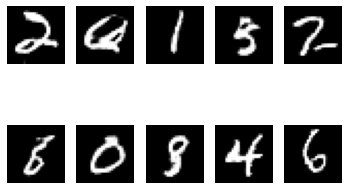

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6261 - g_loss: 1.0008
Epoch 32/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6294 - g_loss: 0.9924
Epoch 33/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6263 - g_loss: 0.9937
Epoch 34/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6278 - g_loss: 0.9889
Epoch 35/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6289 - g_loss: 0.9854
Epoch 36/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6292 - g_loss: 0.9817
Epoch 37/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6312 - g_loss: 0.9777
Epoch 38/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6307 - g_loss: 0.9744
Epoch 39/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6296 - g_loss: 0.9762
Epoch 40/100
1875/1875 [==============================] - 3

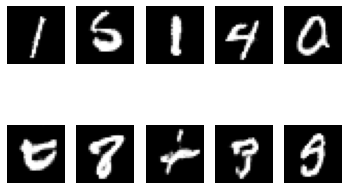

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6323 - g_loss: 0.9682
Epoch 42/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6326 - g_loss: 0.9656
Epoch 43/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6335 - g_loss: 0.9657
Epoch 44/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6327 - g_loss: 0.9645
Epoch 45/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6351 - g_loss: 0.9547
Epoch 46/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6340 - g_loss: 0.9591
Epoch 47/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6369 - g_loss: 0.9531
Epoch 48/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6332 - g_loss: 0.9607
Epoch 49/100
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6348 - g_loss: 0.9538
Epoch 50/100
1875/1875 [==============================] - 3

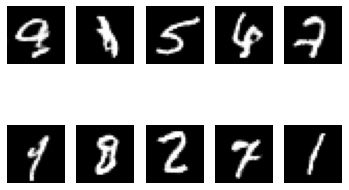

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6340 - g_loss: 0.9563
Epoch 52/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6353 - g_loss: 0.9529
Epoch 53/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6368 - g_loss: 0.9505
Epoch 54/100
1875/1875 [==============================] - 35s 19ms/step - d_loss: 0.6363 - g_loss: 0.9492
Epoch 55/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6371 - g_loss: 0.9494
Epoch 56/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6361 - g_loss: 0.9508
Epoch 57/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6377 - g_loss: 0.9488
Epoch 58/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6359 - g_loss: 0.9484
Epoch 59/100
1875/1875 [==============================] - 37s 19ms/step - d_loss: 0.6368 - g_loss: 0.9459
Epoch 60/100
1875/1875 [==============================] - 3

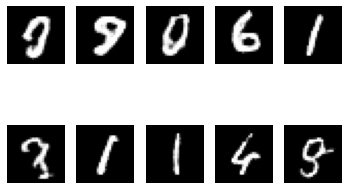

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6381 - g_loss: 0.9470
Epoch 62/100
1875/1875 [==============================] - 37s 19ms/step - d_loss: 0.6376 - g_loss: 0.9475
Epoch 63/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6389 - g_loss: 0.9424
Epoch 64/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6372 - g_loss: 0.9460
Epoch 65/100
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6386 - g_loss: 0.9435
Epoch 66/100
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6378 - g_loss: 0.9458
Epoch 67/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6368 - g_loss: 0.9462
Epoch 68/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6365 - g_loss: 0.9461
Epoch 69/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6369 - g_loss: 0.9502
Epoch 70/100
1875/1875 [==============================] - 3

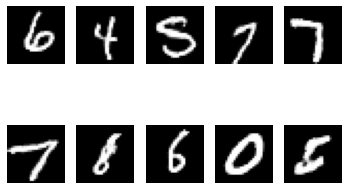

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6353 - g_loss: 0.9510
Epoch 72/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6357 - g_loss: 0.9500
Epoch 73/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6360 - g_loss: 0.9513
Epoch 74/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6376 - g_loss: 0.9477
Epoch 75/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6351 - g_loss: 0.9517
Epoch 76/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6357 - g_loss: 0.9560
Epoch 77/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6369 - g_loss: 0.9508
Epoch 78/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6382 - g_loss: 0.9460
Epoch 79/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6365 - g_loss: 0.9503
Epoch 80/100
1875/1875 [==============================] - 3

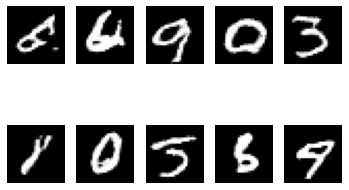

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6355 - g_loss: 0.9545
Epoch 82/100
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6366 - g_loss: 0.9509
Epoch 83/100
1875/1875 [==============================] - 37s 19ms/step - d_loss: 0.6366 - g_loss: 0.9517
Epoch 84/100
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6373 - g_loss: 0.9496
Epoch 85/100
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6361 - g_loss: 0.9522
Epoch 86/100
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6359 - g_loss: 0.9539
Epoch 87/100
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6361 - g_loss: 0.9530
Epoch 88/100
1875/1875 [==============================] - 44s 23ms/step - d_loss: 0.6366 - g_loss: 0.9494
Epoch 89/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6335 - g_loss: 0.9583
Epoch 90/100
1875/1875 [==============================] - 3

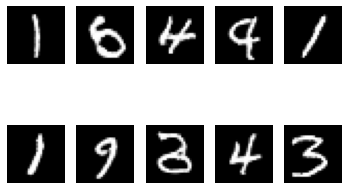

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6357 - g_loss: 0.9603
Epoch 92/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6340 - g_loss: 0.9598
Epoch 93/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6347 - g_loss: 0.9601
Epoch 94/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6354 - g_loss: 0.9586
Epoch 95/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6327 - g_loss: 0.9657
Epoch 96/100
1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6350 - g_loss: 0.9621
Epoch 97/100
1875/1875 [==============================] - 42s 22ms/step - d_loss: 0.6349 - g_loss: 0.9607
Epoch 98/100
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6337 - g_loss: 0.9633
Epoch 99/100
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6332 - g_loss: 0.9656
Epoch 100/100
1875/1875 [==============================] - 

In [11]:
gan.fit(df,
       epochs=100,
       shuffle=True,
       callbacks=[PlotCallback()])

In [12]:
# just apply with pair(not all pairs)
class RGAN(keras.Model):
    def __init__(self, x_dim, z_dim): # dim: tuple
        super(RGAN, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(RGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        inputs = Input(shape = (self.z_dim, ))
        
        h = Dense(128*7*7, activation='relu')(inputs)
        h = Reshape((7, 7, 128))(h) # 7, ,7 128
        h = BatchNormalization(momentum=0.8)(h)
        h = deConvBlock(64)(h) # 14, 14, 64
        h = deConvBlock(32)(h) # 28, 28, 32
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(h) # 28, 28, 1
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape = self.x_dim)
        
        h = ConvBlock(16)(inputs)
        h = ConvBlock(32)(h)
        h = ConvBlock(64)(h)
        h = Flatten()(h)
        
        outputs = Dense(1)(h)
        return Model(inputs, outputs, name='discriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            fake_pred = self.discriminator(fake)
            real_pred = self.discriminator(x)
            
            fake_loss = self.loss_fn(fake_labels, fake_pred - real_pred)
            real_loss = self.loss_fn(real_labels, real_pred - fake_pred)

            d_loss = 0.5*(fake_loss + real_loss)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            preds = self.generator(noise)
            fake_pred = self.discriminator(preds)
            real_pred = self.discriminator(x)
            
            g_loss = self.loss_fn(real_labels, fake_pred - real_pred)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}



In [13]:
gan = RGAN(train_X.shape[1:], 100)

gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

Epoch 1/101
1872/1875 [============================>.] - ETA: 0s - d_loss: 0.5066 - g_loss: 1.3025

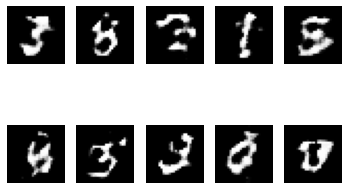

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5066 - g_loss: 1.3023
Epoch 2/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.5218 - g_loss: 1.2406
Epoch 3/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.5439 - g_loss: 1.2192
Epoch 4/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.5363 - g_loss: 1.2429
Epoch 5/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.5295 - g_loss: 1.2697
Epoch 6/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.5282 - g_loss: 1.2898
Epoch 7/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.5307 - g_loss: 1.3136
Epoch 8/101
1875/1875 [==============================] - 27s 15ms/step - d_loss: 0.5398 - g_loss: 1.2958
Epoch 9/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.5543 - g_loss: 1.2588
Epoch 10/101
1875/1875 [==============================] - 27s 14ms/

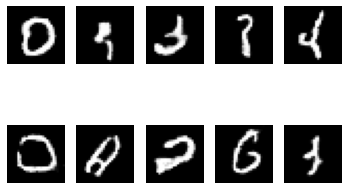

1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.5807 - g_loss: 1.1841
Epoch 12/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.5890 - g_loss: 1.1543
Epoch 13/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.5980 - g_loss: 1.1202
Epoch 14/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6040 - g_loss: 1.0992
Epoch 15/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6111 - g_loss: 1.0662
Epoch 16/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6181 - g_loss: 1.0414
Epoch 17/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6218 - g_loss: 1.0241
Epoch 18/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6244 - g_loss: 1.0070
Epoch 19/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6277 - g_loss: 0.9932
Epoch 20/101
1875/1875 [==============================] - 1

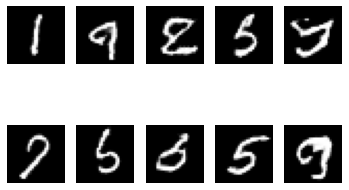

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6335 - g_loss: 0.9620
Epoch 22/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6356 - g_loss: 0.9562
Epoch 23/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6379 - g_loss: 0.9395
Epoch 24/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6385 - g_loss: 0.9365
Epoch 25/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6396 - g_loss: 0.9325
Epoch 26/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6423 - g_loss: 0.9208
Epoch 27/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6437 - g_loss: 0.9131
Epoch 28/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6450 - g_loss: 0.9079
Epoch 29/101
1875/1875 [==============================] - 33s 18ms/step - d_loss: 0.6468 - g_loss: 0.9016
Epoch 30/101
1875/1875 [==============================] - 2

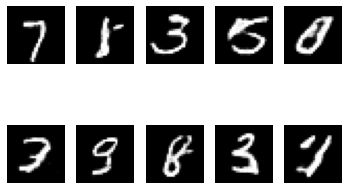

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6498 - g_loss: 0.8878
Epoch 32/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6496 - g_loss: 0.8861
Epoch 33/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6509 - g_loss: 0.8843
Epoch 34/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6526 - g_loss: 0.8767
Epoch 35/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6516 - g_loss: 0.8765
Epoch 36/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6538 - g_loss: 0.8704
Epoch 37/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6535 - g_loss: 0.8702
Epoch 38/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6557 - g_loss: 0.8651
Epoch 39/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6550 - g_loss: 0.8628
Epoch 40/101
1875/1875 [==============================] - 3

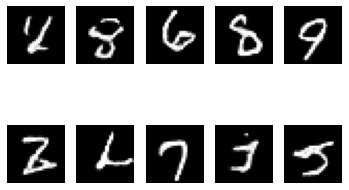

1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6589 - g_loss: 0.8515
Epoch 42/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6571 - g_loss: 0.8552
Epoch 43/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6570 - g_loss: 0.8539
Epoch 44/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6590 - g_loss: 0.8493
Epoch 45/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6589 - g_loss: 0.8471
Epoch 46/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6591 - g_loss: 0.8474
Epoch 47/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6607 - g_loss: 0.8414
Epoch 48/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6609 - g_loss: 0.8399
Epoch 49/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6612 - g_loss: 0.8386
Epoch 50/101
1875/1875 [==============================] - 3

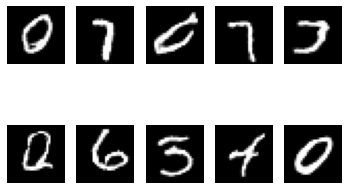

1875/1875 [==============================] - 35s 18ms/step - d_loss: 0.6624 - g_loss: 0.8359
Epoch 52/101
1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6607 - g_loss: 0.8380
Epoch 53/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6618 - g_loss: 0.8364
Epoch 54/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6619 - g_loss: 0.8361
Epoch 55/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6625 - g_loss: 0.8325
Epoch 56/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6622 - g_loss: 0.8327
Epoch 57/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6614 - g_loss: 0.8328
Epoch 58/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6636 - g_loss: 0.8294
Epoch 59/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6620 - g_loss: 0.8309
Epoch 60/101
1875/1875 [==============================] - 18s 9

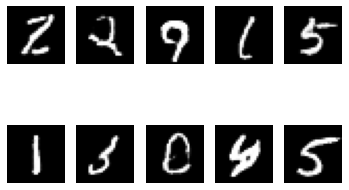

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6643 - g_loss: 0.8257
Epoch 62/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6628 - g_loss: 0.8295
Epoch 63/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6640 - g_loss: 0.8258
Epoch 64/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6634 - g_loss: 0.8271
Epoch 65/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6633 - g_loss: 0.8266
Epoch 66/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6649 - g_loss: 0.8240
Epoch 67/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6641 - g_loss: 0.8248
Epoch 68/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6642 - g_loss: 0.8249
Epoch 69/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6638 - g_loss: 0.8250
Epoch 70/101
1875/1875 [==============================] - 18s 9ms/s

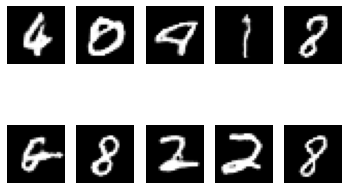

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6629 - g_loss: 0.8255
Epoch 72/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6634 - g_loss: 0.8254
Epoch 73/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6632 - g_loss: 0.8257
Epoch 74/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6644 - g_loss: 0.8232
Epoch 75/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6637 - g_loss: 0.8244
Epoch 76/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6637 - g_loss: 0.8250
Epoch 77/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6639 - g_loss: 0.8243
Epoch 78/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6656 - g_loss: 0.8209
Epoch 79/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6640 - g_loss: 0.8224
Epoch 80/101
1875/1875 [==============================] - 18s 9ms

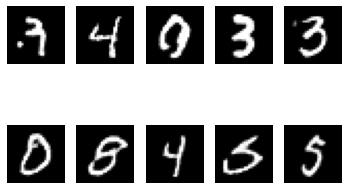

1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6642 - g_loss: 0.8230
Epoch 82/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6626 - g_loss: 0.8278
Epoch 83/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6639 - g_loss: 0.8248
Epoch 84/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6648 - g_loss: 0.8220
Epoch 85/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6633 - g_loss: 0.8261
Epoch 86/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6633 - g_loss: 0.8253
Epoch 87/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6628 - g_loss: 0.8266
Epoch 88/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6646 - g_loss: 0.8237
Epoch 89/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6633 - g_loss: 0.8252
Epoch 90/101
1875/1875 [==============================] - 18s 9ms/st

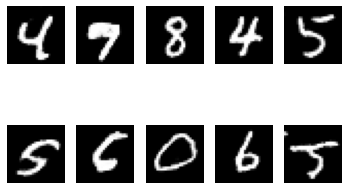

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6638 - g_loss: 0.8251
Epoch 92/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6628 - g_loss: 0.8272
Epoch 93/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6639 - g_loss: 0.8238
Epoch 94/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6637 - g_loss: 0.8254
Epoch 95/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6621 - g_loss: 0.8273
Epoch 96/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6630 - g_loss: 0.8279
Epoch 97/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6612 - g_loss: 0.8310
Epoch 98/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6636 - g_loss: 0.8284
Epoch 99/101
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6638 - g_loss: 0.8257
Epoch 100/101
1875/1875 [==============================] - 18s 9ms/

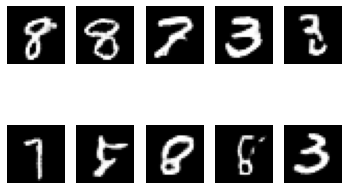

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6645 - g_loss: 0.8241


In [14]:
gan.fit(df,
       epochs=101,
       shuffle=True,
       callbacks=[PlotCallback()])